# Traffic Fines

![img/traffic_fines.jpg](img/traffic_fines.jpg)

{octicon}`calendar` Jan, 2023

{bdg-primary-line}`Open Data` {bdg-primary-line}`Choropleth maps`

## Background
To make a data project, first you need data. One possibility is to collect it yourself, making it a *quantifying* project for a start. Another alternative is to directly ask for the data to the people who have it. And then, there is sometimes the option of downloading it from the internet as [open data](https://en.wikipedia.org/wiki/Open_data), which is what I did for this project.

I was curious about what the local government was publishing as open data. The datasets I found were not particularly exciting, much of it was about municipal finances and some demographics. But I came across the information of traffic fines during the last few years, and I thought I would give it a try.

With open data, institutions aim to become more transparent to the public. The data is shared, it is available for anyone to take a look at it, but usually it is not that simple. You need a data project to make sense of it. Once you convert the numbers into graphics and insightful information, only then the data comes alive and you can figure out what is going on.

## The data
I downloaded the CSV files from this link, containing traffic fines in my town from 2018 to 2022.

[https://www.gipuzkoairekia.eus/](https://www.gipuzkoairekia.eus/es/datu-irekien-katalogoa/-/openDataSearcher/detail/detailView/b4db402e-6fd6-48f9-bd0a-a137902a3f1a)

In [66]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily
from IPython.display import Markdown

# Read the data
usecols=[0, 4, 5, 6, 7, 8] # Useful columns
fines_2018 = pd.read_csv("data/multas_2018.csv", sep=";", decimal=",", usecols=usecols)
fines_2019 = pd.read_csv("data/multas_2019.csv", sep=";", decimal=",", usecols=usecols)
fines_2020 = pd.read_csv("data/multas_2020.csv", sep=";", decimal=",", usecols=usecols)
fines_2021 = pd.read_csv("data/multas_2021.csv", sep=";", decimal=",", usecols=usecols)
fines_2022 = pd.read_csv("data/multas_2022.csv", sep=";", decimal=",", usecols=usecols)

# Concatenate the data from different years into a unique dataset
fines = pd.concat([fines_2018, fines_2019, fines_2020, fines_2021, fines_2022])

# Rename columns
fines = fines.rename(columns={"AÑO": "year",
                              "NOMBRE CALLE": "street",
                              "CALIFICACION": "category",
                              "NRO MULTAS": "fines",
                              "IMPORTE PAGADO": "paid",
                              "IMPORTE PENDIENTE DE PAGO EN EJECUTIVA": "unpaid"})
print(fines)

    year                street   category  fines    paid  unpaid
0   2018                   NaN       LEVE      2    15.0    0.00
1   2018  GELTOKIEN ENPARANTZA      GRAVE      3     0.0  234.95
2   2018  GELTOKIEN ENPARANTZA       LEVE     52   640.8  279.15
3   2018  GELTOKIEN ENPARANTZA  MUY GRAVE      2   500.0    0.00
4   2018    EUSKADI ENPARANTZA      GRAVE      4   200.0  244.95
..   ...                   ...        ...    ...     ...     ...
75  2022              IBAIONDO      GRAVE      2   200.0    0.00
76  2022              IBAIONDO       LEVE     45   385.0  259.65
77  2022  ESKUALDEKO OSPITALEA      GRAVE     34  2100.0  949.80
78  2022  ESKUALDEKO OSPITALEA       LEVE     62   675.0  533.55
79  2022                 ANTIO       LEVE      1     0.0    0.00

[340 rows x 6 columns]


As shown in the dataframe above, the number of fines related to the year and street is already aggregated into three different categories:
- LEVE, for mild traffic offences.
- GRAVE, for serious ones.
- MUY GRAVE, for very serious ones.

## Data validation
Data inspection shows some missing values.

In [67]:
# Dataframe inspection
fines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340 entries, 0 to 79
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      340 non-null    int64  
 1   street    337 non-null    object 
 2   category  340 non-null    object 
 3   fines     340 non-null    int64  
 4   paid      340 non-null    float64
 5   unpaid    340 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 18.6+ KB


Only 3 rows out of 340 have missing values, and with few fine quantities, so I just drop them.

In [68]:
# Rows with NaN values
print(fines[fines["street"].isna()])

   year street   category  fines   paid  unpaid
0  2018    NaN       LEVE      2   15.0     0.0
0  2020    NaN  MUY GRAVE      2  120.0     0.0
0  2021    NaN  MUY GRAVE      1    0.0     0.0


In [69]:
# Discard rows with NaN values
fines = fines[~fines["street"].isna()]

In [70]:
# Check dataframe
fines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337 entries, 1 to 79
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      337 non-null    int64  
 1   street    337 non-null    object 
 2   category  337 non-null    object 
 3   fines     337 non-null    int64  
 4   paid      337 non-null    float64
 5   unpaid    337 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 18.4+ KB


As data types are already correct, no further measures are needed.

## Exploratory Data Analysis

### Fines by street
QUESTION: Which are the streets with the greater number of fines? Locate the hotspots.

In [71]:
# Group by streets and fine category, then sum up fines
fines_streets = fines.groupby(["street", "category"])["fines"].sum().unstack()

# Rearrange column order: LEVE, GRAVE, MUY GRAVE
fines_streets = fines_streets.iloc[:, [1, 0, 2]]

# Create new column with the total amount of fines: LEVE + GRAVE + MUY GRAVE
fines_streets["total"] = fines_streets.sum(axis=1)

# Sort values by total amount of fines
fines_streets = fines_streets.sort_values("total", ascending=False)

print(fines_streets)

category                        LEVE  GRAVE  MUY GRAVE  total
street                                                       
ZELAI-ARIZTI PARKEA            916.0    2.0        NaN  918.0
SEKUNDINO ESNAOLA KALEA        619.0   29.0        2.0  650.0
ESKUALDEKO OSPITALEA           422.0  165.0        NaN  587.0
GELTOKIEN ENPARANTZA           504.0   21.0        6.0  531.0
PIEDAD KALEA                   429.0   32.0        1.0  462.0
BIDEZAR KALEA                  352.0   25.0        NaN  377.0
KALEBARREN                     269.0   25.0        NaN  294.0
ELIZKALE                       202.0   49.0        3.0  254.0
SAN GREGORIO KALEA             169.0   21.0        3.0  193.0
LEGAZPI KALEA                  167.0    6.0        NaN  173.0
ELKANO KALEA                   143.0   22.0        1.0  166.0
EUSKADI ENPARANTZA             137.0   12.0        NaN  149.0
URDANETA HIRIBIDEA             122.0   21.0        1.0  144.0
JAI-ALAI KALEA                 123.0    6.0        NaN  129.0
ESTEBAN 

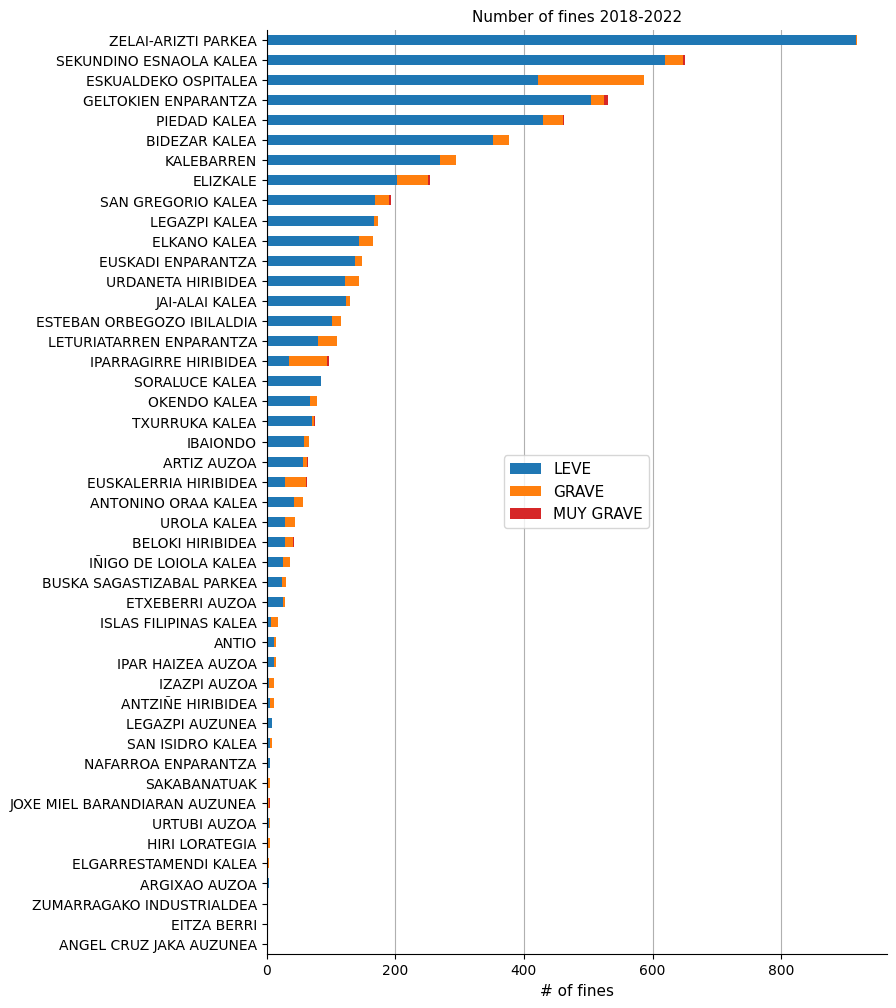

In [72]:
# Define color palette
palette = ["tab:blue", "tab:orange", "tab:red"]

# Plot
fig, ax = plt.subplots(figsize=(8, 12))

fines_streets.sort_values("total").drop("total", axis=1).plot(ax=ax, kind="barh",
                                                              stacked=True, color=palette)

ax.grid(axis="x")
ax.set_axisbelow(True)
ax.set_title("Number of fines 2018-2022", size=11)
ax.set_xlabel("# of fines", fontsize=11)
ax.set_ylabel("")
ax.legend(fontsize=11, loc='center')
sns.despine()

plt.show()

I decided to put this information into a choropleth. That for, I first needed to form a map with the streets and neighborhoods of the town. I draw each polygon by hand using https://geojson.io/.

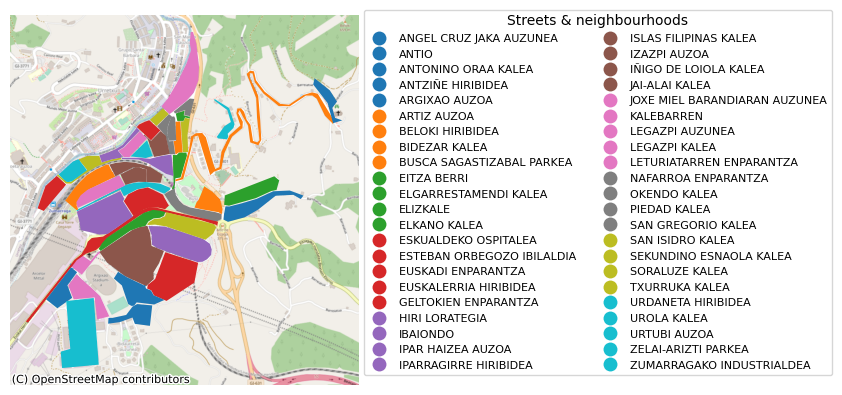

In [73]:
# Read geographical data of streets into a geopandas dataframe
zelai = gpd.read_file("geojson/zelai_arizti_parkea.geojson")
zelai["street"] = "ZELAI-ARIZTI PARKEA"
sekundino = gpd.read_file("geojson/sekundino_esnaola_kalea.geojson")
sekundino["street"] = "SEKUNDINO ESNAOLA KALEA"
ospitalea = gpd.read_file("geojson/eskualdeko_ospitalea.geojson")
ospitalea["street"] = "ESKUALDEKO OSPITALEA"
geltokien = gpd.read_file("geojson/geltokien_enparantza.geojson")
geltokien["street"] = "GELTOKIEN ENPARANTZA"
piedad = gpd.read_file("geojson/piedad_kalea.geojson")
piedad["street"] = "PIEDAD KALEA"
bidezar = gpd.read_file("geojson/bidezar_kalea.geojson")
bidezar["street"] = "BIDEZAR KALEA"
kalebarren = gpd.read_file("geojson/kalebarren.geojson")
kalebarren["street"] = "KALEBARREN"
elizkale = gpd.read_file("geojson/elizkale.geojson")
elizkale["street"] = "ELIZKALE"
gregorio = gpd.read_file("geojson/san_gregorio_kalea.geojson")
gregorio["street"] = "SAN GREGORIO KALEA"
legazpi = gpd.read_file("geojson/legazpi_kalea.geojson")
legazpi["street"] = "LEGAZPI KALEA"
elkano = gpd.read_file("geojson/elkano_kalea.geojson")
elkano["street"] = "ELKANO KALEA"
euskadi = gpd.read_file("geojson/euskadi_enparantza.geojson")
euskadi["street"] = "EUSKADI ENPARANTZA"
urdaneta = gpd.read_file("geojson/urdaneta_hiribidea.geojson")
urdaneta["street"] = "URDANETA HIRIBIDEA"
jai = gpd.read_file("geojson/jai_alai_kalea.geojson")
jai["street"] = "JAI-ALAI KALEA"
orbegozo = gpd.read_file("geojson/esteban_orbegozo_ibilaldia.geojson")
orbegozo["street"] = "ESTEBAN ORBEGOZO IBILALDIA"
leturia = gpd.read_file("geojson/leturiatarren_enparantza.geojson")
leturia["street"] = "LETURIATARREN ENPARANTZA"
iparragirre = gpd.read_file("geojson/iparragirre_hiribidea.geojson")
iparragirre["street"] = "IPARRAGIRRE HIRIBIDEA"
soraluze = gpd.read_file("geojson/soraluze_kalea.geojson")
soraluze["street"] = "SORALUZE KALEA"
okendo = gpd.read_file("geojson/okendo_kalea.geojson")
okendo["street"] = "OKENDO KALEA"
txurruka = gpd.read_file("geojson/txurruka_kalea.geojson")
txurruka["street"] = "TXURRUKA KALEA"
ibaiondo = gpd.read_file("geojson/ibaiondo.geojson")
ibaiondo["street"] = "IBAIONDO"
artiz = gpd.read_file("geojson/artiz_auzoa.geojson")
artiz["street"] = "ARTIZ AUZOA"
euskalerria = gpd.read_file("geojson/euskalerria_hiribidea.geojson")
euskalerria["street"] = "EUSKALERRIA HIRIBIDEA"
oraa = gpd.read_file("geojson/antonino_oraa_kalea.geojson")
oraa["street"] = "ANTONINO ORAA KALEA"
urola = gpd.read_file("geojson/urola_kalea.geojson")
urola["street"] = "UROLA KALEA"
beloki = gpd.read_file("geojson/beloki_hiribidea.geojson")
beloki["street"] = "BELOKI HIRIBIDEA"
loiola = gpd.read_file("geojson/inigo_de_loiola_kalea.geojson")
loiola["street"] = "IÑIGO DE LOIOLA KALEA"
busca = gpd.read_file("geojson/busca_sagastizabal_parkea.geojson")
busca["street"] = "BUSCA SAGASTIZABAL PARKEA"
etxeberri = gpd.read_file("geojson/etxeberri_auzoa.geojson")
etxeberri["street"] = "ETXEBERRI AUZOA"
filipinas = gpd.read_file("geojson/islas_filipinas_kalea.geojson")
filipinas["street"] = "ISLAS FILIPINAS KALEA"
antio = gpd.read_file("geojson/antio.geojson")
antio["street"] = "ANTIO"
ipar = gpd.read_file("geojson/ipar_haizea_auzoa.geojson")
ipar["street"] = "IPAR HAIZEA AUZOA"
izazpi = gpd.read_file("geojson/izazpi_auzoa.geojson")
izazpi["street"] = "IZAZPI AUZOA"
antzine = gpd.read_file("geojson/antzine_hiribidea.geojson")
antzine["street"] = "ANTZIÑE HIRIBIDEA"
legazpi_auzo = gpd.read_file("geojson/legazpi_auzunea.geojson")
legazpi_auzo["street"] = "LEGAZPI AUZUNEA"
isidro = gpd.read_file("geojson/san_isidro_kalea.geojson")
isidro["street"] = "SAN ISIDRO KALEA"
nafarroa = gpd.read_file("geojson/nafarroa_enparantza.geojson")
nafarroa["street"] = "NAFARROA ENPARANTZA"
barandi = gpd.read_file("geojson/joxe_miel_barandiaran_auzunea.geojson")
barandi["street"] = "JOXE MIEL BARANDIARAN AUZUNEA"
urtubi = gpd.read_file("geojson/urtubi_auzoa.geojson")
urtubi["street"] = "URTUBI AUZOA"
lorategia = gpd.read_file("geojson/hiri_lorategia.geojson")
lorategia["street"] = "HIRI LORATEGIA"
elgarrestamendi = gpd.read_file("geojson/elgarrestamendi_kalea.geojson")
elgarrestamendi["street"] = "ELGARRESTAMENDI KALEA"
argixao = gpd.read_file("geojson/argixao_auzoa.geojson")
argixao["street"] = "ARGIXAO AUZOA"
industrialdea = gpd.read_file("geojson/zumarragako_industrialdea.geojson")
industrialdea["street"] = "ZUMARRAGAKO INDUSTRIALDEA"
eitza = gpd.read_file("geojson/eitza_berri.geojson")
eitza["street"] = "EITZA BERRI"
jaka = gpd.read_file("geojson/anjel_cruz_jaka_auzunea.geojson")
jaka["street"] = "ANGEL CRUZ JAKA AUZUNEA"

# Concatenate all dataframes into a unique one
zumarraga = pd.concat([zelai, sekundino, ospitalea, geltokien, piedad, bidezar,
                       kalebarren, elizkale, gregorio, legazpi, elkano, euskadi,
                       urdaneta, jai, orbegozo, leturia, iparragirre, soraluze,
                       okendo, txurruka, ibaiondo, artiz, euskalerria, oraa,
                       urola, beloki, loiola, busca, filipinas, antio, ipar,
                       izazpi, antzine, legazpi_auzo, isidro, nafarroa, barandi,
                       urtubi, lorategia, elgarrestamendi, argixao,
                       industrialdea, eitza, jaka,
                       # etxeberri,
                      ])

# Create a projected reference system to plot with a basemap
zumarraga_3857 = zumarraga.copy()
zumarraga_3857.geometry = zumarraga_3857.geometry.to_crs(epsg=3857)

# Plot with a basemap
fig, ax = plt.subplots()
legend_kwds = {'title': 'Streets & neighbourhoods', 'fontsize': 8,
               'loc': 'upper left', 'bbox_to_anchor': (1, 1.03), 'ncol': 2}
zumarraga_3857.plot(ax=ax, column="street", legend=True, legend_kwds=legend_kwds)
contextily.add_basemap(ax,
                       source=contextily.providers.OpenStreetMap.Mapnik,
                       # source=contextily.providers.CartoDB.PositronNoLabels,
                      )
ax.set_axis_off()

plt.show()

Having made the map, it was all about merging it with the fines dataframe to get the couple of choropleths shown below.

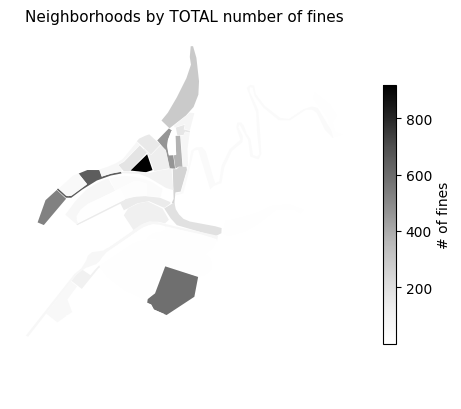

In [74]:
# Merge geographical dataframe with fine by streets dataframe
zumarraga_fines = zumarraga.merge(fines_streets, how="left",
                                  left_on="street", right_on=fines_streets.index)

# Plot a choropleth by total number of fines
fig, ax = plt.subplots()
zumarraga_fines.plot(ax=ax, column="total", legend=True, cmap="Greys",
                    legend_kwds={'label': "# of fines", "shrink": 0.7})
ax.set_title("Neighborhoods by TOTAL number of fines", size=11)
ax.set_axis_off()
plt.show()

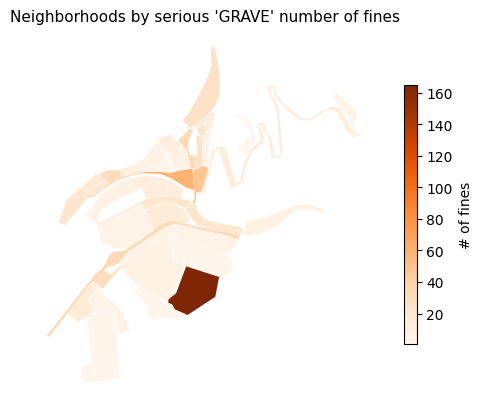

In [75]:
# Plot a choropleth by total number of serious (GRAVE) fines
fig, ax = plt.subplots()
zumarraga_fines.plot(ax=ax, column="GRAVE", legend=True, cmap="Oranges",
                    legend_kwds={'label': "# of fines", "shrink": 0.7})
ax.set_title("Neighborhoods by serious 'GRAVE' number of fines", size=11)
ax.set_axis_off()
plt.show()

### Fines by year
QUESTION: How have the number of fines evolved during the last few years?

In [76]:
# Group by year and fine category, then sum up fines
fines_years = fines.groupby(["year", "category"])["fines"].sum().unstack()

# Rearrange column order: LEVE, GRAVE, MUY GRAVE
fines_years = fines_years.iloc[:, [1, 0, 2]]

# Create new column with the total amount of fines: LEVE + GRAVE + MUY GRAVE
fines_years["total"] = fines_years.sum(axis=1)

print(fines_years)

category  LEVE  GRAVE  MUY GRAVE  total
year                                   
2018      1112    194          4   1310
2019       583    104          2    689
2020      1183     95          1   1279
2021       918    167         11   1096
2022      1604    158         11   1773


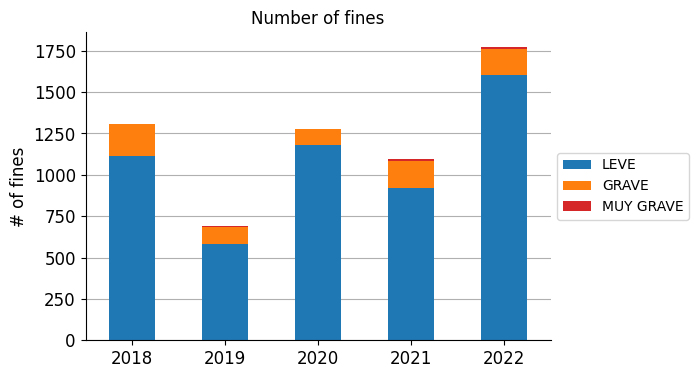

In [77]:
# Plot
fig, ax = plt.subplots(figsize=(6, 4))

fines_years.drop(["total"], axis=1).plot(ax=ax, kind="bar",
                                         stacked=True, color=palette)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12)
ax.set_title("Number of fines", fontsize=12)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("# of fines", fontsize=12)
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', fontsize=10)
sns.despine()

plt.show()

### Fines by year and street
QUESTION: How have the number of fines evolved during the last years in the top 10 fine-prone streets?

In [78]:
# Group by year, street and fine category, then sum up fines
fines_years_streets = fines.groupby(["year", "street", "category"])["fines"].sum().unstack()

# Rearrange column order: LEVE, GRAVE, MUY GRAVE
fines_years_streets = fines_years_streets.iloc[:, [1, 0, 2]]

# Create new column with the total amount of fines
fines_years_streets["total"] = fines_years_streets.sum(axis=1)

print(fines_years_streets)

category                   LEVE  GRAVE  MUY GRAVE  total
year street                                             
2018 ANTIO                  9.0    3.0        NaN   12.0
     ANTONINO ORAA KALEA    1.0    1.0        NaN    2.0
     ARGIXAO AUZOA          1.0    NaN        NaN    1.0
     ARTIZ AUZOA           24.0    1.0        NaN   25.0
     BELOKI HIRIBIDEA      12.0    3.0        NaN   15.0
...                         ...    ...        ...    ...
2022 SORALUCE KALEA         6.0    NaN        NaN    6.0
     TXURRUKA KALEA        43.0    1.0        1.0   45.0
     URDANETA HIRIBIDEA    62.0    5.0        NaN   67.0
     UROLA KALEA            9.0    1.0        NaN   10.0
     ZELAI-ARIZTI PARKEA  209.0    1.0        NaN  210.0

[189 rows x 4 columns]


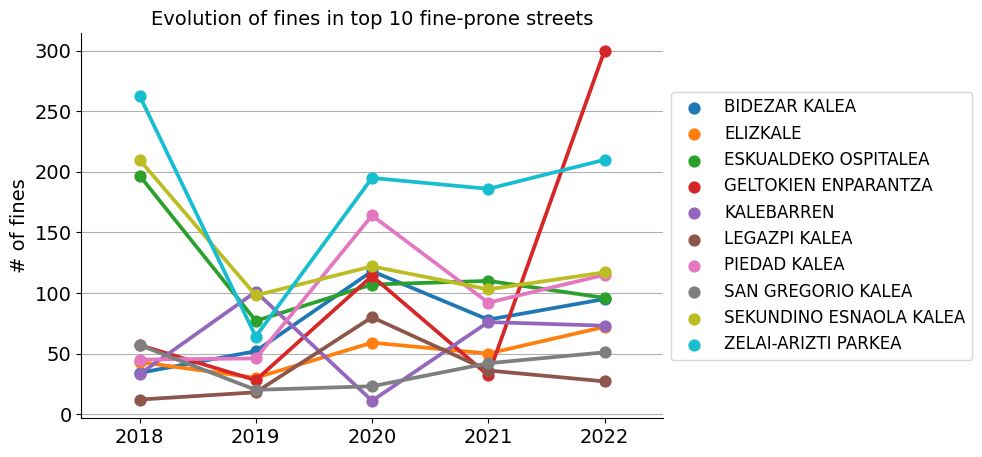

In [79]:
# Create a list with the names of the top 10 fine streets
fines_streets_top10 = fines_streets.iloc[:10].index

# Filter top 10 streets
fines_years_streets = fines_years_streets.reset_index()
fines_years_streets_top10 = fines_years_streets[fines_years_streets["street"]\
                                                .isin(fines_streets_top10)]

# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

sns.pointplot(ax=ax, x="year", y="total", data=fines_years_streets_top10,
              hue="street")

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Evolution of fines in top 10 fine-prone streets", fontsize=14)
ax.set_xlabel("", fontsize=13)
ax.set_ylabel("# of fines", fontsize=14)
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', fontsize=12)
sns.despine()

plt.show()

### Money collected from fines
QUESTION: How much money does the municipality collect from fines?

The data comes with two columns related to the amount of money:
- "IMPORTE PAGADO": which I have renamed as "paid".
- "IMPORTE PENDIENTE DE PAGO EN EJECUTIVA": which I have renamed as "unpaid".

For the sake of clarity, I have added together both columns (I have supposed pending payments will eventually be processed).

In [80]:
# Create new column with the total amount
fines["paid_unpaid"] = fines["paid"] + fines["unpaid"]

# Group by year and fine category, then sum up fines
fines_money = fines.groupby(["year", "category"])["paid_unpaid"].sum().unstack()

# Rearrange column order: LEVE, GRAVE, MUY GRAVE
fines_money = fines_money.iloc[:, [1, 0, 2]]

# Create new column with the total amount of money raised
fines_money["total"] = fines_money.sum(axis=1)

print(fines_money)

category      LEVE     GRAVE  MUY GRAVE     total
year                                             
2018      19548.05  16623.60    1704.95  37876.60
2019       8359.39   8695.95     500.00  17555.34
2020      11778.40   6099.65     500.00  18378.05
2021      14145.21  14438.45    1134.95  29718.61
2022      27313.80  13633.91    4499.75  45447.46


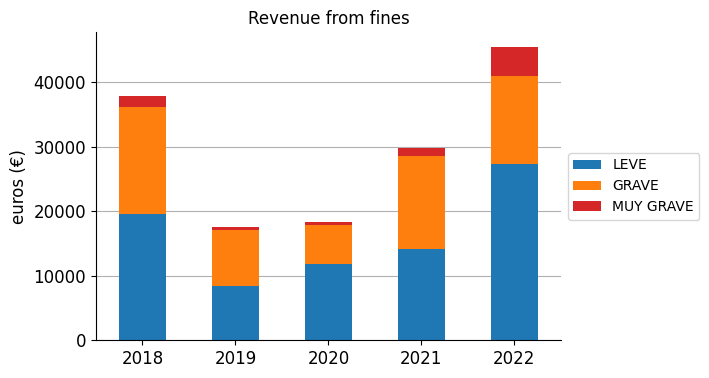

In [81]:
# Plot
fig, ax = plt.subplots(figsize=(6, 4))

fines_money.drop(["total"], axis=1).plot(ax=ax, kind="bar",
                                         stacked=True, color=palette)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12)
ax.set_title("Revenue from fines", fontsize=12)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("euros (€)", fontsize=12)
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', fontsize=10)
sns.despine()

plt.show()

Finally, I find it interesting to summarise this graphic into one single figure: how much money do they collect roughly per year?

In [82]:
# How much money do they collect on average per year?
avg_year = fines_money["total"].mean()

# The same value roughly
avg_year_rough = round(avg_year, -3)

display(Markdown(f"The amount of money collected per year is roughly **{avg_year_rough:.0f} €**"))

The amount of money collected per year is roughly **30000 €**

## Conclusions
This project was about shedding light on a freely available open data set. In this case, I downloaded the files of traffic fines in my town. The analysis consisted in exploring ways of representing the data to get a clear picture of its contents. This kind of work should be useful for the people involved, to watch out for trends and follow up new policies. And for the public, to effectively make the information transparent for all of us.